In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm
import cv2
import os
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (

In [2]:
DATASET_PATH = 'D:/fashionmnist/'

### Convert from ubyte file

In [181]:
# def convert(imgf, labelf, outf, n):
#     f = open(imgf, "rb")
#     o = open(outf, "w")
#     l = open(labelf, "rb")

#     f.read(16)
#     l.read(8)
#     images = ['label']
#     images += []

#     for i in range(n):
#         image = [ord(l.read(1))]
#         for j in range(28*28):
#             image.append(ord(f.read(1)))
#         images.append(image)

#     for image in images:
#         o.write(",".join(str(pix) for pix in image)+"\n")
#     f.close()
#     o.close()
#     l.close()

# convert("train-images-idx3-ubyte", "train-labels-idx1-ubyte",
#         "mnist_train2.csv", 60000)
# convert("t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte",
#         "mnist_test2.csv", 10000)

In [3]:
df = pd.read_csv(DATASET_PATH+'fashion-mnist_train.csv')

In [6]:
df.shape

(60000, 785)

In [4]:
df = df.sort_values('label').reset_index(drop=True)


### Image Equalization

In [6]:

def increase_brightness(img):
    array_m = np.ma.masked_equal(img,0)
    unique_px, count_px = np.unique(array_m, return_counts=True)
    rate = 255/np.argmax(np.unique(array_m, return_counts=True)[1])
    array_m = np.minimum(array_m*rate,[255]*len(img))
    array_m = np.ma.filled(array_m,0).astype('uint8')
    return array_m

def clahe_equalize(img):
    return cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img)    
    
# convert values[0,255] to [0,1]
# arg 'array': a row of pixel values without label
# arg 'threshold': values<threshold -> 0; values>=threshold -> 1
def to_binary(img,threshold=200):
    # ori: 0=white, 255=black
    # converted: 1=white, 0=black
    array = img.copy()
    array[array<=threshold] = 0 #black
    array[array>threshold] = 1 
    return array

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = cm.binary, **options)
    plt.axis("off")


In [ ]:
import datetime
equalized_arrays = []
starttime = datetime.datetime.now()
for i,row in enumerate(df.drop(labels=['label'],axis=1).values):
    if i%1000==0:
        print('Checkpoint: ',i, ' Time used: ', datetime.datetime.now()-starttime)
    equalized_arrays.append(clahe_equalize(increase_brightness(row)))

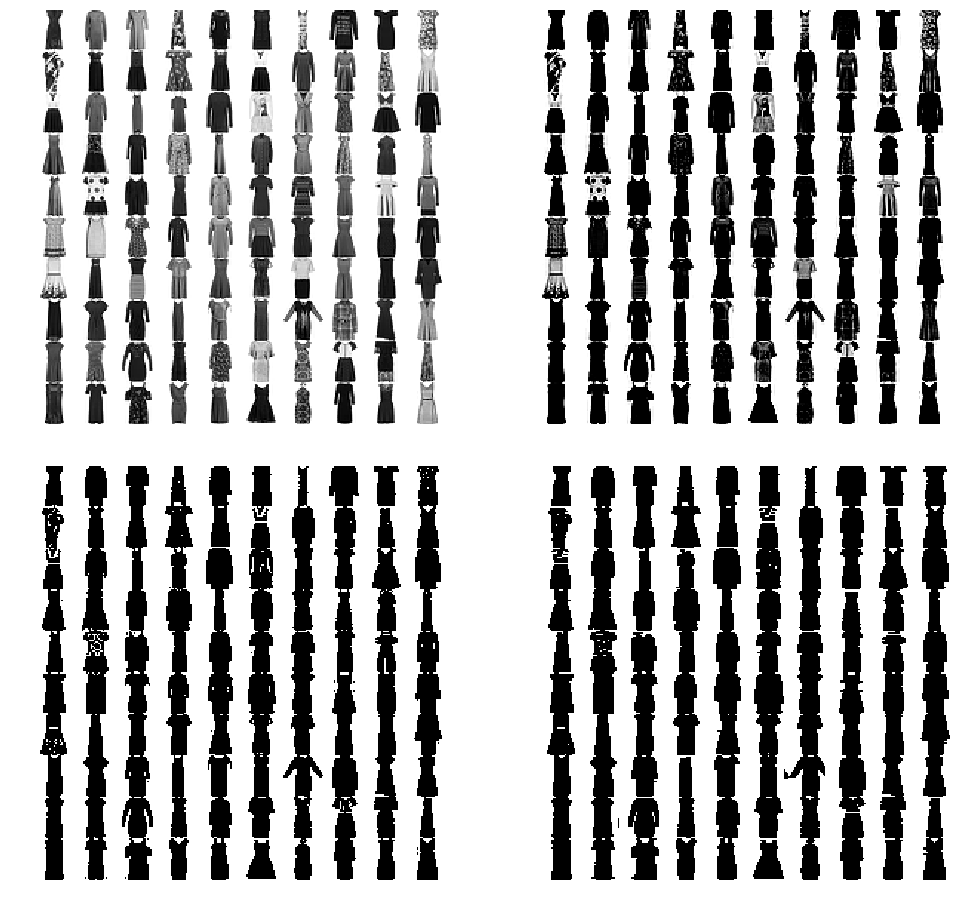

In [168]:
plt.figure(figsize=(18, 16))
plot_no = 1
class_no = 3
random_num = np.random.randint(6000*class_no,6000*class_no+6000,100)
train_pixel = df.drop(labels=['label'],axis=1).values
# for i np.random.randint(0,len(opening_train[0]),25):
# plt.subplot(111); plot_digits([opening_train[2][idx] for idx in np.random.randint(0,len(opening_train[2]),150)],images_per_row=15)
plt.subplot(221); plot_digits([train_pixel[idx] for idx in random_num],images_per_row=10)
plt.subplot(222); plot_digits([equalized_arrays[idx] for idx in random_num],images_per_row=10)
plt.subplot(223); plot_digits([binary_arrays[idx] for idx in random_num],images_per_row=10)
plt.subplot(224); plot_digits([morph_arrays[idx] for idx in random_num],images_per_row=10)
# plt.subplot(223); plot_digits([yoyo2[idx] for idx in random_num],images_per_row=10)
plt.subplots_adjust(wspace=0,hspace=0.1) 

In [155]:
binary_arrays = []
for img in equalized_arrays:
    binary_arrays.append(to_binary(img,threshold=30))
    
morph_arrays = []
for img in binary_arrays:
#     morph_arrays.append(cv2.morphologyEx(np.float32(cv2.morphologyEx(np.float32(cv2.morphologyEx(np.float32(img), cv2.MORPH_CLOSE, (5,5))), cv2.MORPH_OPEN, (5,5))), cv2.MORPH_CLOSE, (5,5)))
    morph_arrays.append(cv2.dilate(cv2.morphologyEx(np.float32(cv2.morphologyEx(np.float32(cv2.morphologyEx(np.float32(img), cv2.MORPH_CLOSE, (3,3))), cv2.MORPH_OPEN, (5,5))), cv2.MORPH_OPEN,(3,3)), (3,3)))

In [17]:
equalized_arrays = []
for row in df.drop(labels=['label'],axis=1).values:
    equalized_arrays.append(equalize(row))

### Save images

In [171]:
train_label = df['label'].values

for i in range(10):
    directory = DATASET_PATH+'fashion-img/train_morph/'+str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)

counts = np.zeros(10)
for i,x in enumerate(np.asarray(morph_arrays[:])):
    plt.imsave('fashion-img/train_morph/'+str(train_label[i])+'/'+str(int(counts[train_label[i]]))+'.png',x.reshape(28,28),cmap='gray')
    counts[train_label[i]]+=1

In [9]:
test_df = pd.read_csv('mnist_test2.csv',names=df.columns.values)
test_label = test_df['label'].values
equalized_arrays = []
for row in test_df.drop(labels=['label'],axis=1).values:
    equalized_arrays.append(to_binary(clahe_equalize(increase_brightness(row)),threshold=30))
    
morph_arrays_test = []
for row in equalized_arrays:
    morph_arrays_test.append(cv2.dilate(cv2.morphologyEx(np.float32(cv2.morphologyEx(np.float32(cv2.morphologyEx(np.float32(row), cv2.MORPH_CLOSE, (3,3))), cv2.MORPH_OPEN, (5,5))), cv2.MORPH_OPEN,(3,3)), (3,3)))

for i in range(10):
    directory = DATASET_PATH+'fashion-img/test_morph/'+str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)

counts = np.zeros(10)
for i,x in enumerate(np.asarray(morph_arrays_test[:])):
    plt.imsave('fashion-img/test_morph/'+str(test_label[i])+'/'+str(int(counts[test_label[i]]))+'.png',x.reshape(28,28),cmap='gray')
    counts[test_label[i]]+=1

### Read image data

In [18]:
train_imgs = []
for i in range(10):
    mypath = 'fashion-img/train_morph/'+str(i)+'/'
    train_imgs+=[cv2.imread('fashion-img/train_morph/'+str(i)+'/'+f,0) for f in listdir(mypath) if isfile(join(mypath, f))]
print(np.asarray(train_imgs).shape)


(60000, 28, 28)


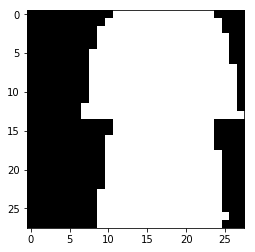

In [126]:
plt.imshow(test_imgs[1111].reshape(28,28),cmap='gray')  # cv2.imshow doesn't work, why?
plt.imsave('test_img.png', test_imgs[1111].reshape(28,28), cmap='gray')

In [14]:
test_imgs = []
for i in range(10):
    mypath = 'fashion-img/test_morph/'+str(i)+'/'
    test_imgs+=[cv2.imread('fashion-img/test_morph/'+str(i)+'/'+f,0) for f in listdir(mypath) if isfile(join(mypath, f))]

In [19]:
# load images has values of 0 and 255, so convert them to 0 and 1
train_imgs = np.where(np.asarray(train_imgs)>0, 1, 0)
test_imgs = np.where(np.asarray(test_imgs)>0, 1, 0)

In [28]:
np.asarray(test_imgs).shape

(10000, 28, 28)

In [17]:
train_labels =[]
for i in range(10):
    train_labels.extend(np.full(6000,i))
    
test_labels =[]
for i in range(10):
    test_labels.extend(np.full(1000,i))

### Train model

In [22]:
# reshape and split images to train and validation set
# one-hot encode the training labels
opening_train = np.asarray(train_imgs)
opening_train = opening_train.reshape(opening_train.shape[0],opening_train.shape[1],opening_train.shape[2],1)
encoded_train_labels = pd.get_dummies(np.asarray(train_labels)).values
X_train, X_val, y_train, y_val = train_test_split(opening_train, encoded_train_labels, test_size=0.33, random_state=42)


In [23]:
# same as the above, but do for test set
test_imgs = np.asarray(test_imgs)
test_imgs = test_imgs.reshape(test_imgs.shape[0],test_imgs.shape[1],test_imgs.shape[2],1)
encoded_test_labels = pd.get_dummies(np.asarray(test_labels)).values
test_imgs, encoded_test_labels = shuffle(test_imgs, encoded_test_labels)

In [ ]:
# check if keras runs on GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [98]:
keras.backend.clear_session()
n_input = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_output = 10


checkpointer = ModelCheckpoint(filepath="D:/fashionmnist/best_weights4.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

model = keras.Sequential([
    # 28x28x1 -> 22x22x8
    keras.layers.Conv2D(input_shape=np.asarray(X_train).shape[1:], filters=8, kernel_size=[5,5], strides=[1,1], padding='same', use_bias='True'),
    keras.layers.LeakyReLU(),
    keras.layers.SpatialDropout2D(rate=.5),
    keras.layers.Conv2D(filters=16, kernel_size=[3,3], strides=[1,1], padding='same', use_bias='True'),
    keras.layers.LeakyReLU(),
    keras.layers.SpatialDropout2D(rate=.5),
    keras.layers.Conv2D(filters=48, kernel_size=[3,3], strides=[1,1], padding='same', use_bias='True'),
    keras.layers.LeakyReLU(),
    keras.layers.SpatialDropout2D(rate=.2),
    keras.layers.Flatten(), 
    keras.layers.Dense(units=128, use_bias='True'),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(rate=0.5),
    # 256 -> 128
    keras.layers.Dense(units=32, use_bias='True'),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=1000, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)

### Load model weights

In [99]:
model.load_weights("best_weights4.hdf5")

### Performance

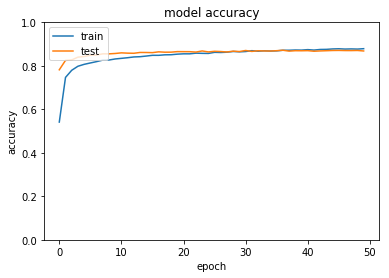

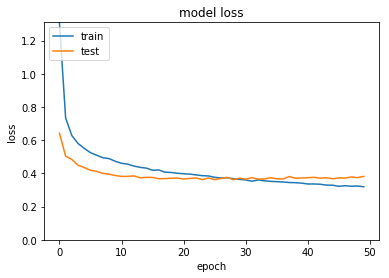

In [14]:
from matplotlib import pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,max(max(history.history['loss']), max(max(history.history['val_loss']),1)))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
loss, accuracy = model.evaluate(test_imgs, encoded_test_labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))
# encoded_y_test
y_pred = model.predict(test_imgs)
y_pred = np.argmax(np.round(y_pred,2),1)
test_label = np.argmax(encoded_test_labels,1)
print ("Precision", precision_score(test_label, y_pred, average='micro'))
print ("Recall", recall_score(test_label, y_pred, average='micro'))
print ("f1_score", f1_score(test_label, y_pred, average='micro'))
print ("confusion_matrix\n", confusion_matrix(test_label, y_pred))

Accuracy: 89.380000
Precision 0.8933
Recall 0.8933
f1_score 0.8933
confusion_matrix
 [[880   2  14  22   2   0  73   0   7   0]
 [  2 978   1  14   4   0   1   0   0   0]
 [ 14   0 817  13 105   1  49   0   1   0]
 [ 16  19   9 901  41   0  11   0   2   1]
 [  0   1 116  25 800   0  57   0   1   0]
 [  0   0   0   0   0 981   0  13   0   6]
 [148   3 103  25  57   0 651   0  13   0]
 [  0   0   0   0   0   7   0 979   1  13]
 [  0   0   3   0   4   1   5   3 983   1]
 [  0   0   0   0   0   3   1  33   0 963]]


### Visualize each layer output

[0, 3, 6]
0 conv2d (?, 28, 28, 8)
1 leaky_re_lu (?, 28, 28, 8)
2 spatial_dropout2d (?, 28, 28, 8)
3 conv2d_1 (?, 28, 28, 16)
4 leaky_re_lu_1 (?, 28, 28, 16)
5 spatial_dropout2d_1 (?, 28, 28, 16)
6 conv2d_2 (?, 28, 28, 48)
7 leaky_re_lu_2 (?, 28, 28, 48)
8 spatial_dropout2d_2 (?, 28, 28, 48)
9 flatten (?, 37632)
10 dense (?, 128)
11 leaky_re_lu_3 (?, 128)
12 dropout (?, 128)
13 dense_1 (?, 32)
14 leaky_re_lu_4 (?, 32)
15 dropout_1 (?, 32)
16 dense_2 (?, 10)
9.0
3
(5, 5, 1, 8)
k:  0
(3, 3, 8, 16)
k:  1
(3, 3, 16, 48)
k:  2


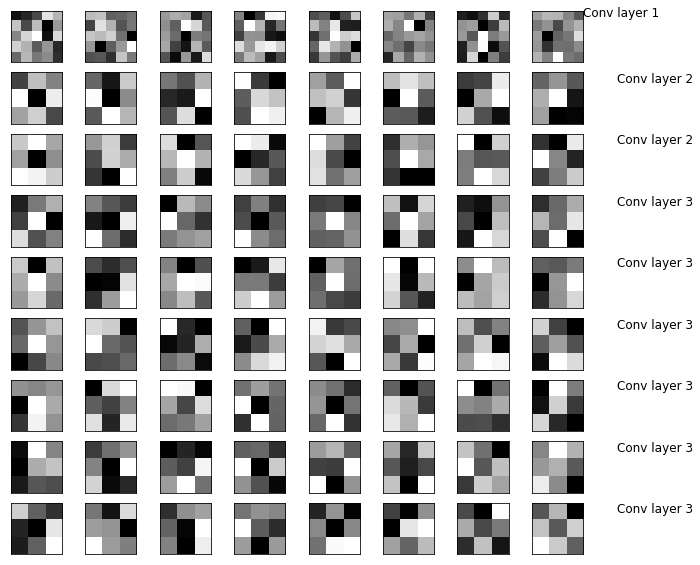

In [105]:
visualizable_layer = [i for i in range(len(model.layers)) if 'conv' in model.layers[i].name]
print(visualizable_layer)
for i in range(len(model.layers)):
    print(i, model.layers[i].name, model.layers[i].output.shape)
n_filters = np.ceil(int(sum([model.layers[i].output.shape[-1] for i in visualizable_layer]))/8)
print(n_filters)

# retrieve weights from the second hidden layer
all_filters = []
for i in visualizable_layer:
    filters = model.layers[i].get_weights()[0]

    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    all_filters.append(filters)

# plot first few filters
n_col, ix, n_channel = 8, 1, 1
plt.figure(figsize=(12,10))
print(len(all_filters))
for k in range(len(all_filters)):
    print(np.asarray(all_filters[k]).shape)
    print('k: ',k)
    for i in range(np.asarray(all_filters[k]).shape[-1]):
        # get the filter
        f = all_filters[k][:, :, :, i]
        # plot each channel separately
        for j in range(n_channel):
            # specify subplot and turn of axis
            plt.subplots_adjust(right=0.80)
            ax = plt.subplot(n_filters, n_col, ix)
            if ix%8==0:
                ax.text(4.5, 0.08, 'Conv layer '+str(k+1), size='large')
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, 0], cmap='gray')
            ix += 1
    if k==len(all_filters)-1:
        plt.savefig(DATASET_PATH+'filter_layers.png')
        
plt.show()

17
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 28, 28, 16)        0         
_______

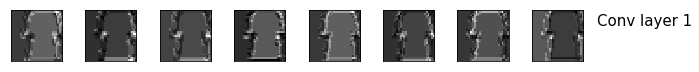

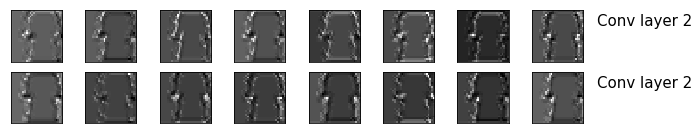

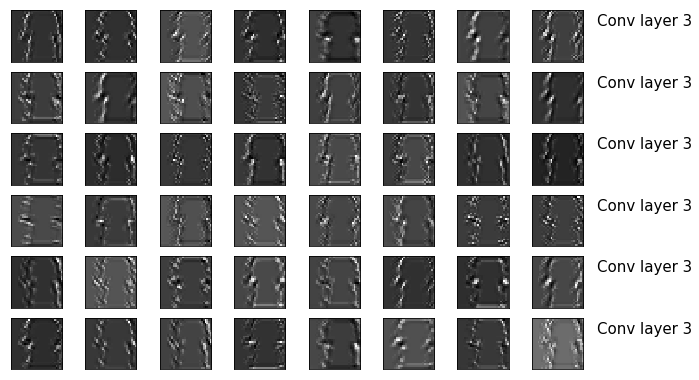

In [124]:
# redefine model to output right after the first hidden layer
layer_models = [keras.models.Model(inputs=model.inputs, outputs=model.layers[i+1].output) for i in visualizable_layer]
layer_models[-1].summary()

for i,m in enumerate(layer_models):
    print(m.layers[1].output.shape)

    # expand dimensions so that it represents a single 'sample'
    test_img = np.expand_dims(test_imgs[1111], axis=0)

    # get feature map for first hidden layer
    feature_maps = m.predict(test_img)
    ix = 1
    plt.figure(figsize=(12,10))
    for _ in range(m.layers[visualizable_layer[i]+1].output.shape[-1]):
        # specify subplot and turn of axis
        plt.subplots_adjust(right=0.80)
        ax = plt.subplot(n_filters, n_col, ix)
        # add text
        if ix%8==0:
            ax.text(35,8, 'Conv layer '+str(i+1), horizontalalignment='left', size=15)        
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.savefig(DATASET_PATH+'activation_layers_'+str(i)+'.png')

plt.show()